### Unifies timelapses to merge them into one dataset
First (ish) notebook to process training data. After setting a data path and a
set of filenames, this notebook will unify the timelapse to the same shape, mask
videos if necessary, and finally save single timelapses and segmentation masks
as .tif and .npy files.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread
from tifffile import imsave

In [2]:
def load_timelapse(basename, timeslice=None, postfix='_GFP_compr.deflate', 
                   plot_distr=True):
    """
    Load a timelapse 3D tif using it's name. Will try to get the file
    {data_path}/{basename}{postfix}.tif
    
    Arguments
    ---------
        basename: str
            The basename of the timelapse to load. This prefix is consistent for
            all types of data corresponding to this microscope timelapse.
        postfix: str
            Load a file that ends with postfix (excluding file extension), by
            default `_GFP_compr.deflate`.
        timeslice: (int, int)
            Option to slice the temporal dimension in the timelapse. Used as
            start and stop index. Defaults to None.
        plot_distr: bool
            Wheather to draw the distribution of pixel intensities. Defaults to
            True.
    Returns
    -------
        signal_chnl: np.array of shape [TxHxW], dtype uint16
            The loaded timelapse.
    """
    signal_chnl_fname = f'{data_path}/{basename}{postfix}.tif'
    signal_chnl = imread(signal_chnl_fname)
    assert signal_chnl.dtype == np.uint16, 'Tif must be unsigned 16 bit integer!'
    if timeslice is not None:
        signal_chnl = signal_chnl[timeslice[0]:timeslice[1]]

    T, H, W = signal_chnl.shape
    framw_min = np.min(signal_chnl, axis=(1,2))
    print(f'\n\n=== `{basename}` tif loaded ===\nTxHxW: {T}x{H}x{W}\n'
          f'dtype: {signal_chnl.dtype}\nmin:{signal_chnl.min()}, '
          f'max:{signal_chnl.max()}\nFrame wise min: {framw_min}')

    if plot_distr:
        make_hist_plots(signal_chnl, (0, -1), title='Initial tif')
    return signal_chnl

In [3]:

def load_timelapse_mask(basename, postfix='_Transmission_compr.deflate_mask1'):
    """
    Load a 2D npy mask using it's name. Will try to get the file
    {data_path}/{basename}{postfix}.npy. Mask may corresbond to micro channel
    segmentation from `00_segment_bg.ipynb` script.
    
    Arguments
    ---------
        basename: str
            The basename of the mask to load. This prefix is consistent for all
            types of data corresponding to this microscope timelapse.
        postfix: str
            Load a file that ends with postfix (excluding file extension), by
            default `Transmission_compr.deflate_mask1`.
    Returns
    -------
        mask: np.array of shape [HxW], dtype bool
            The loaded mask.
    """
    mask_fname = f'{data_path}/{basename}{postfix}.npy'
    if not os.path.exists(mask_fname):
        print(f'Mask file not found: {mask_fname}')
        return None
    mask = np.load(mask_fname)
    H, W = mask.shape
    print(f'=== `{basename}` npy mask loaded ===\nHxW: {H}x{W}\n')
    return mask

In [4]:
def make_hist_plots(signal_chnl, frame_indxs, title='', new_fig=True, show=True):
    """
    Create a matplotlib figure with two histograms corresponding to two frames
    pixel intensity distribution.
    
    Arguments
    ---------
        signal_chnl: np.array of shape [TxHxW] of dtype uint16
            The loaded timelapse.
        frame_indxs: (int, int)
            The two frame indices.
        title: str
            The title of the plot. Defaults to ''.
        new_fig: bool
            Wheather to draw on existing figure or make a new one. Defaults to
            True.
        show: bool
            Run plt.show() of not. Defaults to True.
    """
    if new_fig:
        plt.figure()
    [hist(signal_chnl[i], f'frame t_{i}') for i in frame_indxs]
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(.9, 5000)
    plt.xlabel('Pixel intensity (u16bit int)')
    plt.ylabel('Count')
    plt.title(title)
    plt.legend()
    if show:
        plt.show()

In [5]:
def hist(frame_data, lbl=''):
    """
    Draw one histogram from frame data on currently active figure. Samples
    100,000 pixel values.
    
    Arguments
    ---------
        frame_data: np.array of shape [H,W]
            Array representing one frame.
        lbl: str
            Label for legend.
    """
    frame_data_subs = np.random.choice(frame_data.flatten(), 100000)
    plt.hist(frame_data_subs, bins=int(2**10), label=lbl, alpha=.5)

In [6]:
def mask_timelapse(signal_chnl, mask):
    """
    Masks a timelapse using a passed mask.
    
    Arguments
    ---------
        signal_chnl: np.array of shape [TxHxW] 
            The unmasked timelapse.
        mask: np.array of shape [HxW]
            The boolean mask where False values will be set to black in the
            timelapse. May also be None in which case no masking is performed.
    Returns
    -------
        mask: np.array of shape [TxHxW]
            The masked timelapse.
    """
    if mask is not None:
        signal_chnl[:, ~mask] = 0
        print('Masking timelapse.')
    else:
        print('Mask was `None` - no masking.')
    return signal_chnl

In [7]:
def offset_intensity(signal_chnl, offset_intensity):
    """
    Offset the intensity of a timelapse towards zero. 
    
    Arguments
    ---------
        signal_chnl: np.array of shape [TxHxW] 
            The timelapse.
        offset_intensity: int
            The value that will be subtracted from the timelapse. Values smaller
            than the offset will be capped to 0.
    Returns
    -------
        signal_chnl: np.array of shape [TxHxW] 
            The timelapse.
    """
    blw_mask = signal_chnl < offset_intensity
    print(f'Offsetting by {offset_intensity}. {blw_mask.sum()}'
          f'({blw_mask.sum()/blw_mask.size}) pixels (prop) below offset value.')
    signal_chnl[blw_mask] = offset_intensity # to avoid overflow
    signal_chnl -= offset_intensity
    return signal_chnl

In [8]:
def adjust_timelapse_shape(signal_chnl, mask=None, to_shape=(2920, 5764), 
                           H_slice=(420, 2500), W_slice=None, plot_distr=False):
    """
    Adjust the timelapse shape, and potentially the mask correspondingly. 
    
    Arguments
    ---------
        signal_chnl: np.array of shape [TxHxW] 
            The timelapse to adjust.
        mask: np.array of shape [HxW]
            The mask to adjust in the same way as the timelapse. Defaults be
            None. 
        to_shape: (int, int)    
            The target height and width. Timelapse should be smaller than these
            values - this is padding the timelapse (and mask).
        H_slice: (int, int)
            The height (Y-dim) to slice to. This is post padding. Passed values 
            are used as start and stop indices.
        W_slice: (int, int)
            The width (X-dim) to slice to. This is post padding. Passed values 
            are used as start and stop indices.
        plot_distr: bool
            Wheather to draw the distribution of pixel intensities. Defaults to
            True.
    Returns
    -------
        signal_chnl, mask: np.array of shape [TxHxW], 
                           np.array of shape [H,W]
            The shape-adjusted timelapse and mask.
    """
    print(f'Padding timelapse to shape {to_shape}', end='...')
    # pad the timelapse and matching mask to a given shape
    toH, toW = to_shape
    H, W = signal_chnl.shape[1:]
    padH, padW = (toH-H)//2, (toW-W)//2
    signal_chnl = np.pad(signal_chnl, ((0,0), (padH,padH), (padW,padW)), mode='constant') 
    if mask is not None:
        mask = np.pad(mask, ((padH,padH), (padW,padW)), mode='constant') 
    
    if H_slice is not None:
        print(f'slicing height to {H_slice}', end='...')
        signal_chnl = signal_chnl[:, H_slice[0]:H_slice[1]]
        if mask is not None:
            mask = mask[H_slice[0]:H_slice[1]]
    
    if W_slice is not None:
        print(f'slicing width to {W_slice}', end='...')
        signal_chnl = signal_chnl[:, :, W_slice[0]:W_slice[1]]
        if mask is not None:
            mask = mask[:, W_slice[0]:W_slice[1]]
    
    print('Done.')
    if plot_distr:
        make_hist_plots(signal_chnl, (0, -1), title='Post processing')
    return signal_chnl, mask

In [9]:
def save_timelapse_and_mask(signal_chnl, mask, basename):
    """
    Save the passed timelase and mask using the basename only (without a
    postfix).
    
    Arguments
    ---------
        signal_chnl: np.array of shape [TxHxW] 
            The timelapse to save {data_path}/{basename}.tif
        mask: np.array of shape [HxW]
            The mask to save {data_path}/{basename}.npy. May be None. 
        basename: str
            The basename of the timelapse and mask to save. This prefix is
            consistent for all types of data corresponding to this microscope
            timelapse.
    """
    fname =f'{data_path}/{basename}.tif'
    print(f'Saving adjusted timelapse: {fname}')
    imsave(fname, signal_chnl, photometric='minisblack', 
           compression='deflate', bigtiff=True)
    if mask is not None:
        fname = fname.replace('.tif', '.npy')
        print(f'Saving adjusted mask: {fname}')
        np.save(fname, mask)

In [10]:
def process_timelapses(tlapse_names, timelslices, scnd_maskings, offsets, plot_distr):
    """
    The base function that will process a list of microscope timelapses
    identified by a list of basenames.
    
    Arguments
    ---------
        tlapse_names: [str, str, ...]
            The basenames of the timelapses to iterate.
        timelslices: [(int,int), (int,int), ...]
            The timeslices corresbonding to a basename. Pass None to keep all
            frames.
        scnd_maskings: [bool, bool, ...]
            Whether to look for a second mask with postfix `_second_mask`
            corresbonding to a basename. Timelapse will be masked a second time.
        offsets: [int, int, ...]
            Pixel intensity offsets matching a basename/ microscope timelapse. 
        plot_distr: bool
            Weather to plot the pixel distribution throughout preprocessing.
    """
    for i in range(len(tlapse_names)):
        basename, timelslice = tlapse_names[i], timelslices[i]
        scnd_masking, offset = scnd_maskings[i], offsets[i]
        signal = load_timelapse(basename, timeslice=timelslice, plot_distr=plot_distr)
        signal = offset_intensity(signal, offset)

        if scnd_masking:
            sncd_mask = load_timelapse_mask(basename, postfix='_second_mask')
            signal = mask_timelapse(signal, sncd_mask)

        mask = load_timelapse_mask(basename)
        signal = mask_timelapse(signal, mask)

        signal, mask = adjust_timelapse_shape(signal, mask, plot_distr=plot_distr)
        save_timelapse_and_mask(signal, mask, basename)

### Run below to process list of microscope timelapses 


In [11]:
if __name__ == '__main__' and '__file__' not in globals():
    plt.style.use('dark_background')
    %matplotlib inline
    # %matplotlib qt5
else:
    print('Loaded functions `load_timelapse`, `load_mask` successfully.')



=== `D00_G001` tif loaded ===
TxHxW: 37x2920x5764
dtype: uint16
min:0, max:4095
Frame wise min: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


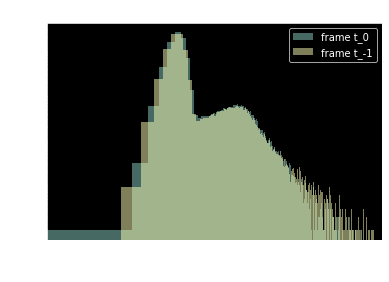

Offsetting by 0. 0(0.0) pixels (prop) below offset value.
=== `D00_G001` npy mask loaded ===
HxW: 2920x5764

Masking timelapse.
Padding timelapse to shape (2920, 5764)...slicing height to (420, 2500)...Done.


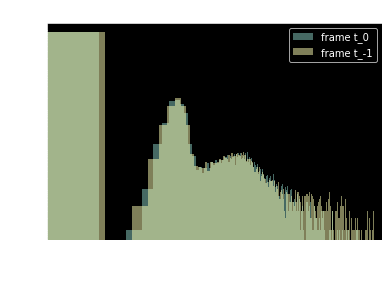

Saving adjusted timelapse: /run/media/loaloa/lbbSSD/training_data//D00_G001.tif
(2080, 5764)
Saving adjusted mask: /run/media/loaloa/lbbSSD/training_data//D00_G001.npy


=== `D04_G004` tif loaded ===
TxHxW: 80x1972x3868
dtype: uint16
min:121, max:4095
Frame wise min: [132 131 132 131 133 133 121 131 132 130 131 132 131 131 132 133 131 129
 129 131 132 130 133 129 131 132 130 124 131 129 130 130 131 129 129 128
 131 131 129 130 128 130 130 130 130 129 131 130 131 130 129 128 128 131
 128 129 130 129 130 128 127 129 130 131 130 127 129 129 131 130 129 129
 129 129 129 129 130 130 130 129]


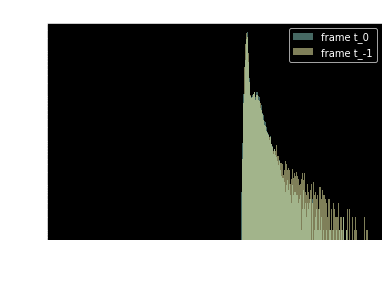

Offsetting by 121. 0(0.0) pixels (prop) below offset value.
=== `D04_G004` npy mask loaded ===
HxW: 1972x3868

Masking timelapse.
Padding timelapse to shape (2920, 5764)...slicing height to (420, 2500)...Done.


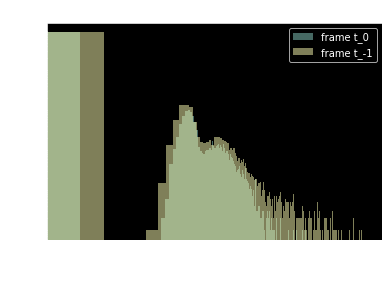

Saving adjusted timelapse: /run/media/loaloa/lbbSSD/training_data//D04_G004.tif
(2080, 5764)
Saving adjusted mask: /run/media/loaloa/lbbSSD/training_data//D04_G004.npy


=== `D19_G035` tif loaded ===
TxHxW: 210x1972x3868
dtype: uint16
min:6, max:4095
Frame wise min: [131 132 114 131 132 130 132 131 132 130 132 131 132 129 130 131 132 132
 132 131 131 130 131 129 128 130 132 131 129 131 129 132 130 130 129 131
 127 130 131 130 131 130 130 131 130 130 131 129 130 128 131 130 130 130
 129 130 116 130 124 131 129 130 129 130 130 125 130 131 125 130 129 130
 130 129 130 122 130 130 127 130  96 129 121 128 129 130 131 128 129 131
 131 129 130 128 130 130 129 130 122   6 129 128 122 116 128 130 129 130
 128 129 130 131 128 129 129 129 128 128 127 130 130 125 131 129 129 129
 130 130 129 127 129 130 129 127 128 130 128 128 126 129 126 128 130 129
 129 127 129  78 130 130 127 128 130 113 128 129 128 129 129 120 129 130
 128 128 130 129 130 130 130 130 127 127 128 130 128 128 131 130 129 130
 12

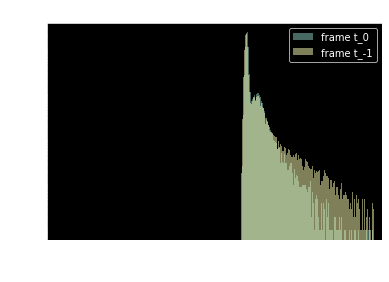

Offsetting by 121. 8(4.9943309349557316e-09) pixels (prop) below offset value.
=== `D19_G035` npy mask loaded ===
HxW: 1972x3868

Masking timelapse.
=== `D19_G035` npy mask loaded ===
HxW: 1972x3868

Masking timelapse.
Padding timelapse to shape (2920, 5764)...slicing height to (420, 2500)...Done.


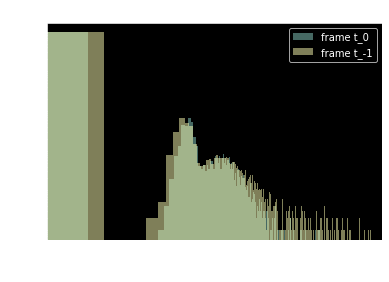

Saving adjusted timelapse: /run/media/loaloa/lbbSSD/training_data//D19_G035.tif
(2080, 5764)
Saving adjusted mask: /run/media/loaloa/lbbSSD/training_data//D19_G035.npy


In [12]:
if __name__ == '__main__' and '__file__' not in globals():
    data_path = '/run/media/loaloa/lbbSSD/training_data/'
    tlapse_names = ['D00_G001', 'D04_G004', 'D19_G035']
    timelslices = [None, (0,80), None]
    scnd_maskings = [False, False, True]
    offsets = [0, 121, 121]
    plot_distr = True

    process_timelapses(tlapse_names, timelslices, scnd_maskings, offsets, plot_distr)